In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import re
import os
import glob
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

In [9]:
base_dir = "/cluster/work/bewi/members/rquiles/zeroshot_amr/data"
out_dir = "/cluster/work/bewi/members/rquiles/zeroshot_amr/sanity_checks"

In [10]:
metadata = pd.read_csv(os.path.join(base_dir, "combined_long_table.csv"))
splits = pd.read_csv(os.path.join(base_dir, "data_splits.csv"))

Number of different sample_id

In [4]:
len(splits)

622935

## HeatMap of Drug Embeddings

In [4]:
fp_path = os.path.join(base_dir, "drug_fingerprints_Mol_selfies.csv")
fps = pd.read_csv(fp_path)

In [5]:
fps

,drug,morgan_512_fp,morgan_1024_fp,MACCS_fp
0,Fulvestrant,0001000100000001000001000000100001001000000000...,0001000000000001000000000000100001001000000000...,0000000000000000000000000000000000000000001000...
1,Paclitaxel,0100000001010000000000000000000001001000000001...,0100000000010000000000000000000001001000000000...,0000000010010000000000000010000000000000000000...
2,Bortezomib,0100000000000000000000000000010001000000101000...,0100000000000000000000000000000001000000001000...,0000000000000000001000000000000000000000000110...
3,Rucaparib,0000000000001000000000000000000001000100000000...,0000000000000000000000000000000001000000000000...,0000000000000000000100000000000000000000001000...
4,Vismodegib,0000000000000000000000000000000001000000000000...,0000000000000000000000000000000001000000000000...,0000000000000000000000000000000000000000000000...
...,...,...,...,...
60,Docetaxel,0100000000010000100000000000000001001010000001...,0100000000010000100000000000000001001000000000...,0000000010010000000000010010000000000000000000...
61,Venetoclax,0000000100010000000000000000011001001000100001...,0000000100000000000000000000010001001000000001...,0000000000000000000000001000000011000010000000...
62,Bexarotene,0000000000000000010000000000000001001000001000...,0000000000000000010000000000000001001000001000...,0000000000000000000000000000000000100000000000...
63,Trametinib,0000000000000001001000000100000001000000000000...,0000000000000001000000000100000001000000000000...,0000000000000000000000100001000000000110001000...


In [9]:
def bitstring_series_to_matrix(series):
    """
    Convert a pandas Series of bitstrings into a 2D numpy array
    Shape: (n_drugs, n_bits)
    """
    return np.array(
        [np.fromiter(s, dtype=np.uint8) for s in series]
    )

X_morgan_512 = bitstring_series_to_matrix(fps["morgan_512_fp"])
X_morgan_1024 = bitstring_series_to_matrix(fps["morgan_1024_fp"])
X_maccs = bitstring_series_to_matrix(fps["MACCS_fp"])

In [19]:
def plot_fp_heatmap(
    X,
    drug_names,
    title,
    max_drugs=100,
    figsize=(20, 6)
):
    """
    Plot fingerprint heatmap
    """
    if max_drugs is not None:
        X = X[:max_drugs]
        drug_names = drug_names[:max_drugs]

    plt.figure(figsize=figsize)

    sns.heatmap(
        X,
        cmap="viridis",
        cbar=True,
        xticklabels=False,
        yticklabels=drug_names
    )

    plot_name = title.lower().replace(" ", "_").replace("fingerprints", "fps") + "_heatmap"
    plt.xlabel("Fingerprint bit")
    plt.ylabel("Drug")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, plot_name), dpi=300, bbox_inches="tight")
    plt.show()

drug_names = fps["drug"].values

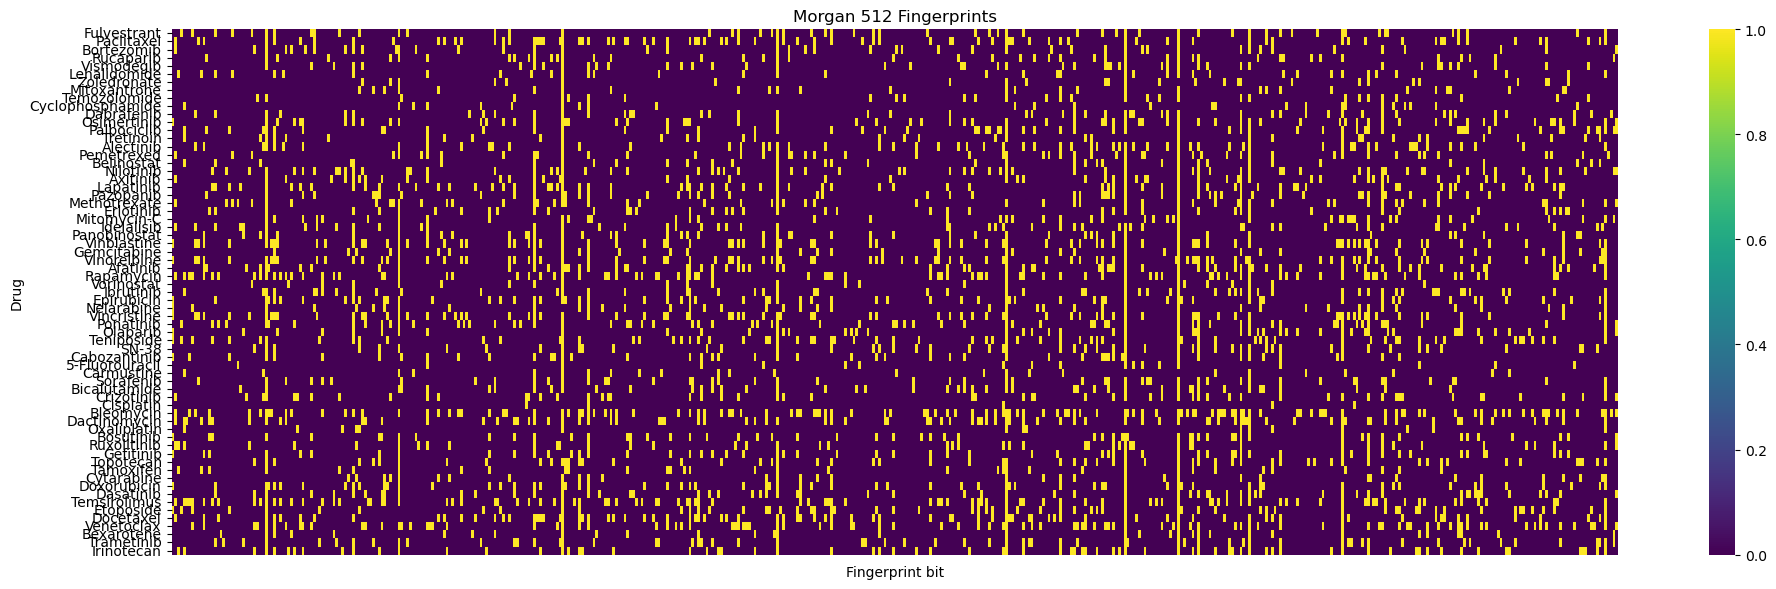

In [20]:
plot_fp_heatmap(
    X_morgan_512,
    drug_names,
    title="Morgan 512 Fingerprints"
)

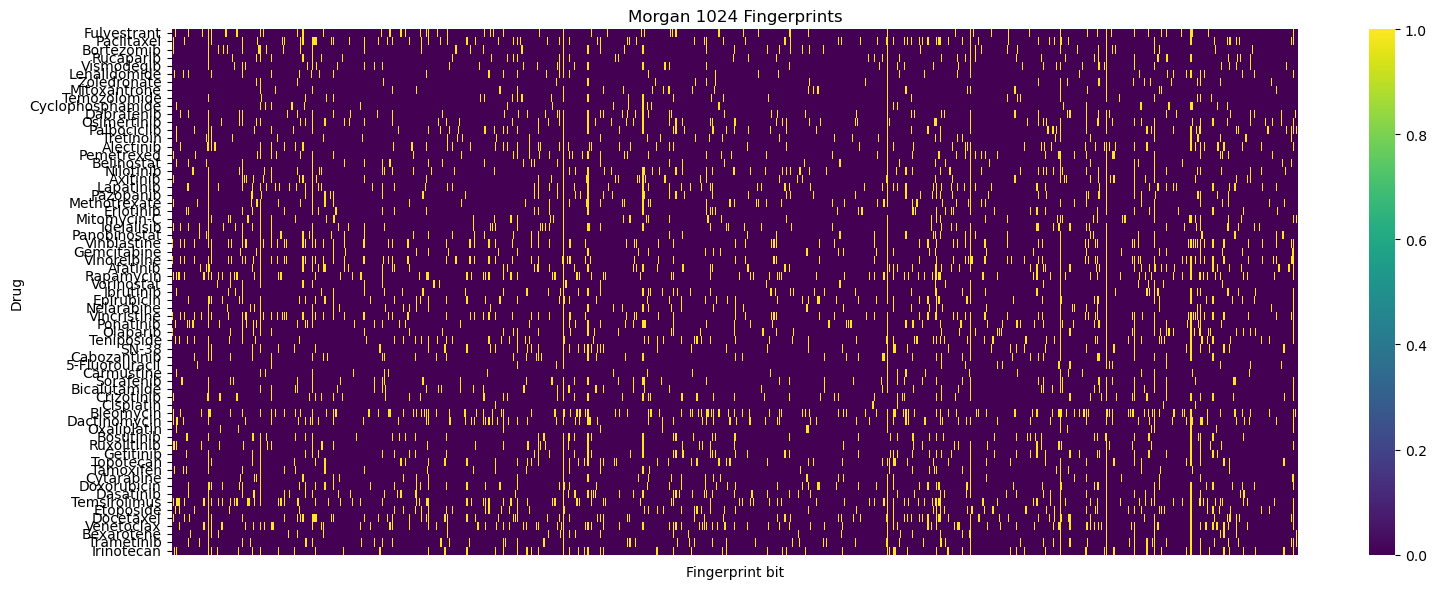

In [21]:
plot_fp_heatmap(
    X_morgan_1024,
    drug_names,
    title="Morgan 1024 Fingerprints",
    figsize=(16, 6)
)

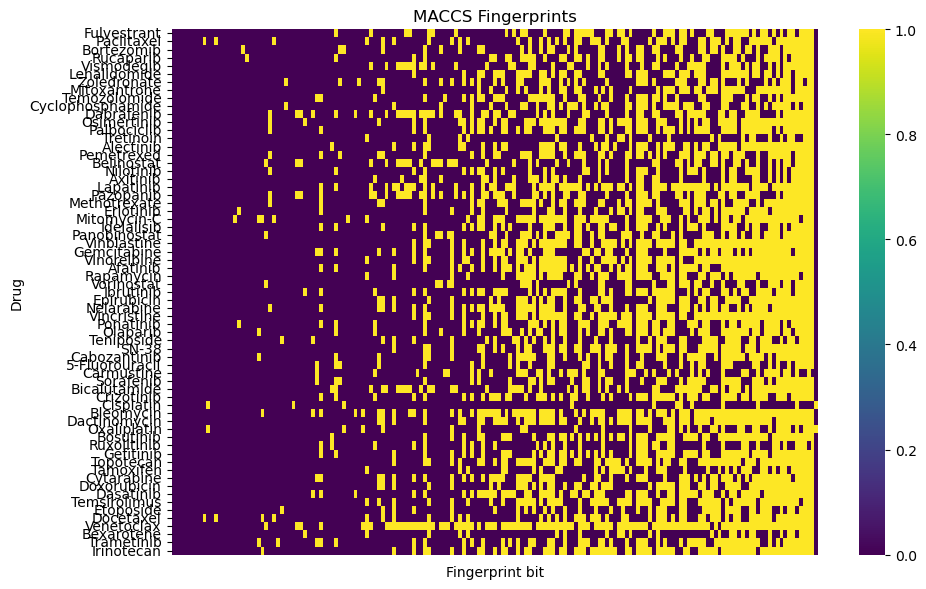

In [22]:
plot_fp_heatmap(
    X_maccs,
    drug_names,
    title="MACCS Fingerprints",
    figsize=(10, 6)
)

Check that the name of the drugs is the same as in the metadata file:

In [8]:
drugs_metadata = metadata["drug"].unique()
drugs = fps["drug"].values

for d in drugs_metadata:
    if d not in drugs:
        print(f"{d} has no corresponding fingerprint")

print("All drugs represented!")

All drugs represented!


## Proportions per set

In [11]:
def generate_sets(df, splits):
    # Process to determine experiment sets
    train_ids = splits[splits["Set"] == "train"]["sample_id"].values
    test_ids = splits[splits["Set"] == "test"]["sample_id"].values

    # Cell lines
    all_lines = df["species"].unique()
    test_lines = df[df["sample_id"].isin(test_ids)]["species"].unique()
    train_lines = df[df["sample_id"].isin(train_ids)]["species"].unique()
    train_only_lines = train_lines[:35]
    train_random_lines = train_lines[35:40]
    zeroshot_lines = [line for line in test_lines if line not in train_lines]

    print(f"All lines ({len(all_lines)}): {all_lines}")
    print("\n")
    print(f"Train-Only lines ({len(train_only_lines)}): {train_only_lines}")
    print("\n")
    print(f"Test lines ({len(test_lines)}): {test_lines}")
    print("\n")
    print(f"Train-Random Split lines ({len(train_random_lines)}): {train_random_lines}")
    print("\n")
    print(f"Zeroshot lines ({len(zeroshot_lines)}): {zeroshot_lines}")

    # Drugs
    all_drugs = df["drug"].unique()
    train_drugs = df[df["species"].isin(train_only_lines)]["drug"].unique()
    zeroshot_drugs = [drug for drug in all_drugs if drug not in train_drugs]

    print(f"\nAll Drugs: ({len(all_drugs)}): {sorted(all_drugs)}")
    print("\n")
    print(f"Train Drugs: ({len(train_drugs)}): {sorted(train_drugs)}")
    print("\n")
    print(f"Zeroshot Drugs: ({len(zeroshot_drugs)}): {sorted(zeroshot_drugs)}")

    # Get test subset of Metadata
    df_test = df[df["sample_id"].isin(test_ids)].copy()

    # Define the following sets (by sample_id)
    df_test["experiment"] = "_" # placeholder

    # a) Random splits
    mask = (df_test["species"].isin(train_random_lines)) & (df_test["drug"].isin(train_drugs))
    df_test.loc[mask, "experiment"] = "random_split"

    # b) Cell line zeroshot
    mask = (df_test["species"].isin(zeroshot_lines)) & (df_test["drug"].isin(train_drugs))
    df_test.loc[mask, "experiment"] = "cell_line_zeroshot"

    # c) Drug zeroshot
    mask = (df_test["species"].isin(train_random_lines)) & (df_test["drug"].isin(zeroshot_drugs))
    df_test.loc[mask, "experiment"] = "drug_zeroshot"

    # d) Drug and Cell line zeroshot
    mask = (df_test["species"].isin(zeroshot_lines)) & (df_test["drug"].isin(zeroshot_drugs))
    df_test.loc[mask, "experiment"] = "cell_line_drug_zeroshot"

    assert len(df_test[df_test["experiment"] == "_"]) == 0

    # Generate 4 different dataframes
    print("Generating the different experiment sets...")
    random_split = df_test[df_test["experiment"] == "random_split"].copy()
    cell_line_zeroshot = df_test[df_test["experiment"] == "cell_line_zeroshot"].copy()
    drug_zeroshot = df_test[df_test["experiment"] == "drug_zeroshot"].copy()
    cell_line_drug_zeroshot = df_test[df_test["experiment"] == "cell_line_drug_zeroshot"].copy()

    return {"Random Split": random_split,
            "Cell line Zeroshot": cell_line_zeroshot,
            "Drug Zeroshot": drug_zeroshot,
            "Cell line Drug Zeroshot": cell_line_drug_zeroshot}

# Get sets from data
sets = generate_sets(metadata, splits)

All lines (46): ['HOP62' 'A172' 'NCIH2030' 'NCISNU1' 'HCT15' 'A498' 'ASPC1' 'MIAPACA2'
 'HT29' 'SW900' 'COLO205' 'CFPAC1' 'LOXIMVI' 'LS180' 'RKO' 'J82' 'C33A'
 'NCIH1792' 'C32' 'LOVO' 'NCIH2347' 'RPMI7951' 'A549' 'NCIH23' 'SKMEL2'
 'AN3CA' 'HS578T' 'KATOIII' 'SNU423' 'HEC1A' 'BT474' 'A427' 'SHP77'
 'CHP212' 'HS766T' 'C3A' 'SW1417' 'SW48' 'PANC0327' 'NCIH1573' 'H4'
 'SW1088' 'NCIH596' 'NCIH661' 'SW1271' 'NCIH2122']


Train-Only lines (35): ['HOP62' 'A172' 'NCIH2030' 'NCISNU1' 'HCT15' 'A498' 'ASPC1' 'MIAPACA2'
 'HT29' 'SW900' 'COLO205' 'CFPAC1' 'LOXIMVI' 'LS180' 'RKO' 'J82' 'C33A'
 'NCIH1792' 'C32' 'LOVO' 'NCIH2347' 'RPMI7951' 'A549' 'NCIH23' 'SKMEL2'
 'AN3CA' 'HS578T' 'KATOIII' 'SNU423' 'HEC1A' 'BT474' 'A427' 'SHP77'
 'CHP212' 'HS766T']


Test lines (11): ['C3A' 'SW1417' 'PANC0327' 'H4' 'SW1088' 'NCIH596' 'NCIH661' 'NCIH1573'
 'SW1271' 'SW48' 'NCIH2122']


Train-Random Split lines (5): ['SW48' 'NCIH1573' 'C3A' 'PANC0327' 'SW1417']


Zeroshot lines (6): ['H4', 'SW1088', 'NCIH596', 'NCIH6

In [7]:
def check_set(set_name, df):
    print(f"{set_name}")
    print(f"Size: {len(df)}")
    sensitive_proportion = len(df[df["response"] == 1]) / len(df)
    print(f"Sensitive proportion: {sensitive_proportion}\n")

for set_name, df in sets.items():
    check_set(set_name, df)

print(f"Overall proportion:{len(metadata[metadata['response'] == 1]) / len(metadata)}")

Random Split
Size: 918173
Sensitive proportion: 0.2778387079559081

Cell line Zeroshot
Size: 1123561
Sensitive proportion: 0.39265869854863245

Drug Zeroshot
Size: 83993
Sensitive proportion: 0.3615658447727787

Cell line Drug Zeroshot
Size: 105000
Sensitive proportion: 0.4386285714285714

Overall proportion:0.3312480763001898


Check informative cell-drug pairs in the set

In [20]:
set = sets["Random Split"]
total = 0
informative = 0

print("Informative pairs:")
for (cell_line, drug), g in set.groupby(["species", "drug"]):
    total += 1
    y_true = g["response"].astype(int).values
    if len(np.unique(y_true)) == 2:
        print(f"{cell_line} - {drug}")
        informative += 1

print(f"\nProportion of informative prediction tasks: {informative/total}")

Informative pairs:
C3A - Cisplatin
C3A - Docetaxel
C3A - Vinorelbine
NCIH1573 - 5-Fluorouracil
NCIH1573 - Cytarabine
NCIH1573 - Doxorubicin
NCIH1573 - Gemcitabine
NCIH1573 - SN-38
NCIH1573 - Vinorelbine
PANC0327 - Cisplatin
PANC0327 - Vinblastine
SW1417 - 5-Fluorouracil
SW1417 - Cytarabine
SW1417 - Docetaxel
SW1417 - Vinorelbine
SW48 - Cisplatin
SW48 - Dactinomycin

Proportion of informative prediction tasks: 0.06319702602230483


## Files Structure

Sample_id order must be the same in metadata and splits file:

In [13]:
np.array_equal(metadata.sample_id.unique(), splits.sample_id)

True

Length of raw_data must the same as sample_ids there are:

In [3]:
files = list(Path(base_dir).glob("raw_data*"))

In [18]:
def check_raw_length(path, n):
    # Read .npy file
    array = np.load(path)
    return len(array) == n

n = len(splits)
for file in files:
    print(check_raw_length(file, n))

True
True
True
True
True
True
True


### KNN Graph comparison

In [5]:
knn_results = pd.read_csv(os.path.join(base_dir, "embeddings_knn_comparisons.csv"))

In [6]:
knn_results

,Unnamed: 0,data_fcr,hvg_1000,hvg_3000,hvg_5000,pcs_10,pcs_25,pcs_50,data_piscvi
0,data_fcr,1.000000,0.015430,0.013565,0.012800,0.005368,0.008773,0.010953,0.010974
1,hvg_1000,0.015430,1.000000,0.258371,0.208709,0.007524,0.015620,0.021837,0.032052
2,hvg_3000,0.013565,0.258371,1.000000,0.522695,0.009135,0.018153,0.025256,0.035572
3,hvg_5000,0.012800,0.208709,0.522695,1.000000,0.008954,0.018126,0.025292,0.038598
4,pcs_10,0.005368,0.007524,0.009135,0.008954,1.000000,0.457270,0.335945,0.005419
5,pcs_25,0.008773,0.015620,0.018153,0.018126,0.457270,1.000000,0.610972,0.009732
6,pcs_50,0.010953,0.021837,0.025256,0.025292,0.335945,0.610972,1.000000,0.012544
7,data_piscvi,0.010974,0.032052,0.035572,0.038598,0.005419,0.009732,0.012544,1.000000


## Check table

In [9]:
base_dir = "/cluster/work/bewi/members/rquiles/zeroshot_amr/experiments/results"
fps = ["MACCS", "morgan_1024", "morgan_512"]
files = [f"{base_dir}/{fp}/metrics.csv" for fp in fps]
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
print(df.columns)

metadata = pd.read_csv("/cluster/work/bewi/members/rquiles/zeroshot_amr/data/combined_long_table.csv")
splits = pd.read_csv("/cluster/work/bewi/members/rquiles/zeroshot_amr/data/data_splits.csv")

Index(['Fingerprint', 'Embedding', 'Set', 'Balanced_Accuracy', 'MCC'], dtype='object')


Create a table with columns: cell line, drug, MCC, type of zero shot split, drug embedding, cell embedding, true proportion of sensitivity/resistance, number of observations

In [25]:
def generate_set_idx(df, splits):
    # Process to determine experiment sets
    train_ids = splits[splits["Set"] == "train"]["sample_id"].values
    test_ids = splits[splits["Set"] == "test"]["sample_id"].values

    # Cell lines
    all_lines = df["species"].unique()
    test_lines = df[df["sample_id"].isin(test_ids)]["species"].unique()
    train_lines = df[df["sample_id"].isin(train_ids)]["species"].unique()
    train_only_lines = train_lines[:35]
    train_random_lines = train_lines[35:40]
    zeroshot_lines = [line for line in test_lines if line not in train_lines]

    # Drugs
    all_drugs = df["drug"].unique()
    train_drugs = df[df["species"].isin(train_only_lines)]["drug"].unique()
    zeroshot_drugs = [drug for drug in all_drugs if drug not in train_drugs]

    # Get test subset of Metadata
    df_test = df[df["sample_id"].isin(test_ids)].copy()

    # Define the following sets (by sample_id)
    df_test["experiment"] = "_" # placeholder

    # a) Random splits
    mask = (df_test["species"].isin(train_random_lines)) & (df_test["drug"].isin(train_drugs))
    df_test.loc[mask, "experiment"] = "random_split"

    # b) Cell line zeroshot
    mask = (df_test["species"].isin(zeroshot_lines)) & (df_test["drug"].isin(train_drugs))
    df_test.loc[mask, "experiment"] = "cell_line_zeroshot"

    # c) Drug zeroshot
    mask = (df_test["species"].isin(train_random_lines)) & (df_test["drug"].isin(zeroshot_drugs))
    df_test.loc[mask, "experiment"] = "drug_zeroshot"

    # d) Drug and Cell line zeroshot
    mask = (df_test["species"].isin(zeroshot_lines)) & (df_test["drug"].isin(zeroshot_drugs))
    df_test.loc[mask, "experiment"] = "cell_line_drug_zeroshot"

    assert len(df_test[df_test["experiment"] == "_"]) == 0

    # Generate 4 different dataframes
    print("Generating the different experiment sets indexes...")
    random_split = df_test[df_test["experiment"] == "random_split"]["sample_id"].values
    cell_line_zeroshot = df_test[df_test["experiment"] == "cell_line_zeroshot"]["sample_id"].values
    drug_zeroshot = df_test[df_test["experiment"] == "drug_zeroshot"]["sample_id"].values
    cell_line_drug_zeroshot = df_test[df_test["experiment"] == "cell_line_drug_zeroshot"]["sample_id"].values

    return {"random": random_split,
            "line": cell_line_zeroshot,
            "drug": drug_zeroshot,
            "line_drug": cell_line_drug_zeroshot}

In [26]:
groups = ["morgan_512", "morgan_1024", "MACCS"]
experiments = ["fcr", "hvgs_1000", "hvgs_3000", "hvgs_5000", "pcs_10", "pcs_25", "pcs_50", "piscvi"]
indexes = generate_set_idx(metadata, splits)

Generating the different experiment sets indexes...


In [30]:
indexes["random"]

array(['95_059_089-lib_1681', '95_059_089-lib_1681',
       '95_059_089-lib_1681', ..., '96_122_022-lib_2608',
       '96_122_022-lib_2608', '96_122_022-lib_2608'], dtype=object)

In [37]:
pred_list = []

for group in groups:
    for exp in experiments:
        if not group == "MACCS" and (exp == "hvgs_3000" or exp == "hvgs_5000"):
            pred_name = f"../experiments/outputs/{group}/{exp}_DRIAMS-any_specific_results/test_set_seed0.csv"
            pred = pd.read_csv(pred_name)
            pred["drug_emb"] = group
            pred["cell_emb"] = exp
            pred["split"] = "_" # placeholder
            pred.loc[pred["sample_id"].isin(indexes["random"]), "split"] = "random"
            pred.loc[pred["sample_id"].isin(indexes["line"]), "split"] = "line"
            pred.loc[pred["sample_id"].isin(indexes["drug"]), "split"] = "drug"
            pred.loc[pred["sample_id"].isin(indexes["line_drug"]), "split"] = "line_drug"
            
            pred_list.append(pred)

pred_df = pd.concat(pred_list, ignore_index=True)
assert len(pred_df[pred_df["split"] == "_"]) == 0

In [38]:
pred_df

,species,sample_id,drug,response,dataset,Predictions,drug_emb,cell_emb,split
0,C3A,95_059_089-lib_1681,Doxorubicin,1.0,any,0.915604,morgan_512,hvgs_3000,drug
1,C3A,95_059_089-lib_1681,Doxorubicin,1.0,any,0.915604,morgan_512,hvgs_3000,drug
2,C3A,95_059_089-lib_1681,Etoposide,1.0,any,0.746994,morgan_512,hvgs_3000,drug
3,C3A,95_059_089-lib_1681,Gemcitabine,1.0,any,0.945085,morgan_512,hvgs_3000,drug
4,C3A,95_059_089-lib_1681,Gemcitabine,1.0,any,0.945085,morgan_512,hvgs_3000,drug
...,...,...,...,...,...,...,...,...,...
8922903,SW1417,96_122_022-lib_2608,Nelarabine,0.0,any,0.000360,morgan_1024,hvgs_5000,drug
8922904,SW1417,96_122_022-lib_2608,Vincristine,0.0,any,0.000882,morgan_1024,hvgs_5000,drug
8922905,SW1417,96_122_022-lib_2608,Venetoclax,0.0,any,0.033228,morgan_1024,hvgs_5000,drug
8922906,SW1417,96_122_022-lib_2608,Osimertinib,0.0,any,0.000132,morgan_1024,hvgs_5000,drug


## MCC per cell line - drug combination

In [3]:
results_dir = "/cluster/work/bewi/members/rquiles/zeroshot_amr/experiments/results"

# find all matching csv files recursively
files = list(Path(results_dir).rglob("mcc_per_cellline_drug*.csv"))
print(f"Found {len(files)} files")

dfs = []
for f in files:
    try:
        df = pd.read_csv(f)
        df["source_file"] = str(f)  # optional but very useful for debugging
        dfs.append(df)
    except Exception as e:
        print(f"Skipping {f}: {e}")

# concatenate
all_mcc = pd.concat(dfs, ignore_index=True)

# save
out_path = os.path.join(results_dir, "mcc_per_cellline_drug_ALL.csv")
all_mcc.to_csv(out_path, index=False)

print(f"Saved combined table to {out_path}")

Found 88 files
Saved combined table to /cluster/work/bewi/members/rquiles/zeroshot_amr/experiments/results/mcc_per_cellline_drug_ALL.csv


In [5]:
df = all_mcc.copy()

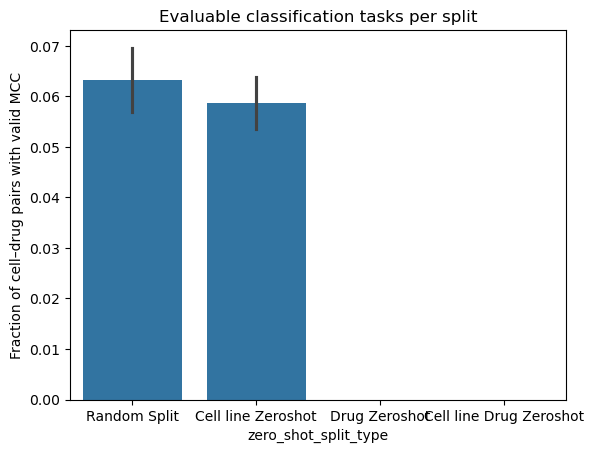

In [6]:
# How much of the table is valuable? If low, most models are being compared to almost no meaningful tasks
df["valid"] = df["MCC"].notna()

sns.barplot(
    data=df,
    x="zero_shot_split_type",
    y="valid",
    estimator="mean",
)
plt.ylabel("Fraction of cell–drug pairs with valid MCC")
plt.title("Evaluable classification tasks per split")
plt.show()

In [ ]:
# MCC distribution per embedding
sns.violinplot(
    data=df[df["MCC"].notna()],
    x="cell_embedding",
    y="MCC",
    hue="drug_embedding",
    cut=0,
    inner="quartile",
)
plt.xticks(rotation=45)
plt.title("Per-pair MCC distribution (valid pairs only)")
plt.show()

In [ ]:
# MCC vs sample size
sns.scatterplot(
    data=df[df["MCC"].notna()],
    x="n_observations",
    y="MCC",
    hue="cell_embedding",
    alpha=0.6,
)
plt.axhline(0, color="black", linestyle="--")
plt.title("MCC vs number of observations per cell–drug pair")
plt.show()

In [ ]:
# MCC vs Class Imbalance
sns.scatterplot(
    data=df[df["MCC"].notna()],
    x="true_prop_sensitive",
    y="MCC",
    alpha=0.6,
)
plt.axvline(0.5, color="black", linestyle="--")
plt.title("Effect of class imbalance on MCC")
plt.show()

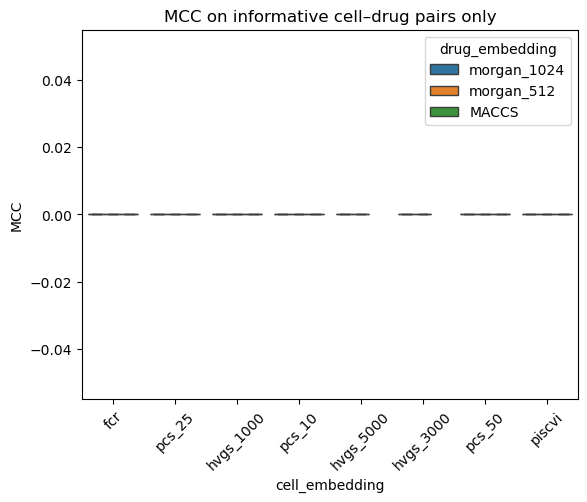

In [8]:
# Informative pairs
informative = df[
    (df["MCC"].notna()) &
    (df["n_observations"] >= 10) &
    (df["true_prop_sensitive"].between(0.2, 0.8))
]

sns.boxplot(
    data=informative,
    x="cell_embedding",
    y="MCC",
    hue="drug_embedding",
)
plt.xticks(rotation=45)
plt.title("MCC on informative cell–drug pairs only")
plt.show()

## Dataset used for training

In [21]:
# Reduced dataset
df_red = pd.read_csv("/cluster/work/bewi/data/tahoe100/metadata/controls_col_cellCode_with_sensitivity_reduced.csv")
df_original = pd.read_csv("/cluster/work/bewi/data/tahoe100/metadata/controls_col_cellCode_with_sensitivity.csv")

In [ ]:
print(f"Samples in original: {len(df_original)}"}
print(f"Samples in reduced: {len(df_red)}"}